# Tests

In [5]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
using Plots
theme(:solarized)

In [6]:
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Main.AgeStructuredModels.model(150, Main.DemographicParameters.StockRecruitCurves.BevetonHolt(1.1310268819475962e-11, 1.4445421556295243e-13, 62.63725167395758, 5.0, 4.420761415847289e11), [3.3594663117871173e6 2.555056808609395e7 … 8.824231836110345e10 8.829850322467499e10; 0.96 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.96 0.0], [0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96  …  0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96], [3.3594663117871173e6, 2.555056808609395e7, 8.200477974415235e7, 1.849036857751277e8, 3.4363008204794115e8, 5.651657119512861e8, 8.544414600074257e8, 1.2146452254678285e9, 1.6474921509710765e9, 2.1534613897204194e9  …  8.771809151502399e10, 8.779155158148238e10, 8.786259495692207e10, 8.793129987574011e10, 8.799774212388702e10, 8.806199510984056e10, 8.812412993391338e10, 8.818421545590387e10, 8.824231836110345e10, 8.829850322467499e10])

In [7]:
R_star = AgeStructuredModels.compute_Rstar(mod)

63.26362419069714

In [8]:
Plots.plot(x,mod.SRCurve.(x) )
Plots.plot!(x, x/lep)
Plots.plot!(x, repeat([R_star], length(x)), linestyle = :dashdot, color = "white")

LoadError: [91mUndefVarError: x not defined[39m

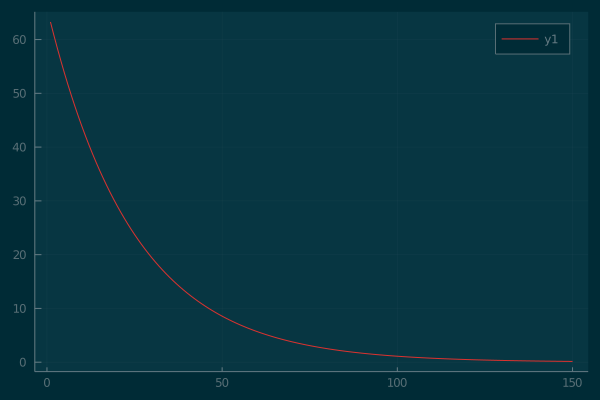

In [9]:
Plots.plot(AgeStructuredModels.stable_age_structure(mod))

# Test `AgeTraitStructuredModel`

In [10]:
include("AgeTraitStructuredModels.jl")

Main.AgeTraitStructuredModels

In [11]:
# initialize a populaiton 
pop = AgeTraitStructuredModels.init(mod,1, 0, 0.1, -5, 20, 0.1)

im = AgeTraitStructuredModels.init_imigrants(pop, 10.0, 15)
print(" ")

In [12]:
function time_step!(population,immigrants)
    dsn, R = AgeTraitStructuredModels.reproduction(population)
    R = AgeTraitStructuredModels.recruitment(R, population )
    dsn, R = AgeTraitStructuredModels.selection(dsn, R, population)
    dsn, R = AgeTraitStructuredModels.immigration(dsn, R, immigrants)
    AgeTraitStructuredModels.ageing!(population, R, dsn)
end 



time_step! (generic function with 1 method)

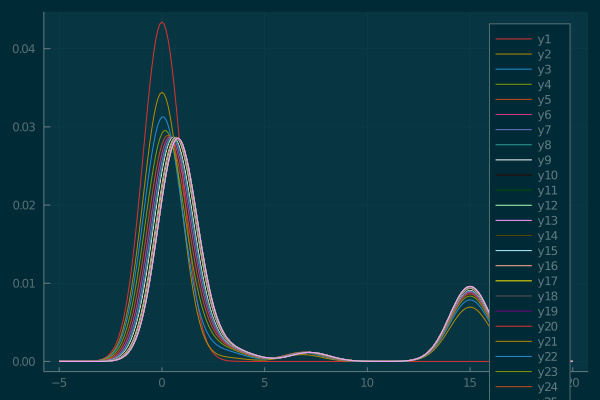

In [13]:
p1 = Plots.plot(pop.grid, pop.trait[:,1])
for i in 1:5000
    time_step!(pop,im)
    if i% 100 == 0
        Plots.plot!(p1, pop.grid, pop.trait[:,1])
    end 
end 
p1

# Test model with analytical solutionmodel 

In [14]:
# analytical methods 
using Distributions
function reproduction(mu, sigma, Vle)
    means = mu
    sds = sqrt((sigma^2)/2 + Vle/2)
    return  means, sds
end 

function reproduction(p, mu, sigma, Vle)
    probs = [p^2, 2*p*(1-p), (1-p)^2]
    means = [mu[1], sum(mu)/2, mu[2]]
    sds = [sqrt((sigma[1]^2)/2 + Vle/2) , sqrt(((sigma[1]^2)/2+(sigma[2]^2)/2)/2 + Vle/2  ), sqrt((sigma[2]^2)/2 + Vle/2)]
    return probs, means, sds
end 

function selection(mu, sigma, s, theta)
    mu_prime = (mu/sigma^2 + s*theta)*(1/sigma^2+s)^(-1)
    sigma_prime = (1/sigma^2+s)^(-1/2)
    print((mu/sigma)^2 + s*theta^2 -(mu_prime/sigma_prime)^2)
    p = exp(-1/2*((mu/sigma)^2 + s*theta^2 -(mu_prime/sigma_prime)^2))
    p *= sigma_prime/sigma
    return mu_prime, sigma_prime, p
end 


function moments(grid, values)
    values = values./sum(values)
    mu = sum(grid .* values)
    sigma = sqrt(sum(values.*(grid.-mu).^2))
    return mu, sigma 
end 

moments (generic function with 1 method)

In [15]:
Survival,Fecundity = [0.9,0.0],[0.0,3.0]
mat = AgeStructuredModels.build_leslie_matrix(2,Survival,Fecundity)
mod2 = AgeStructuredModels.model(2,x -> x*exp(1-x),mat,Survival,Fecundity) 



# initialize a populaiton 
Vle = 1.0
s = 0.1
theta = 0 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -5, 10, 0.1)

AgeStructuredModels.LEP(mod2)


2.7

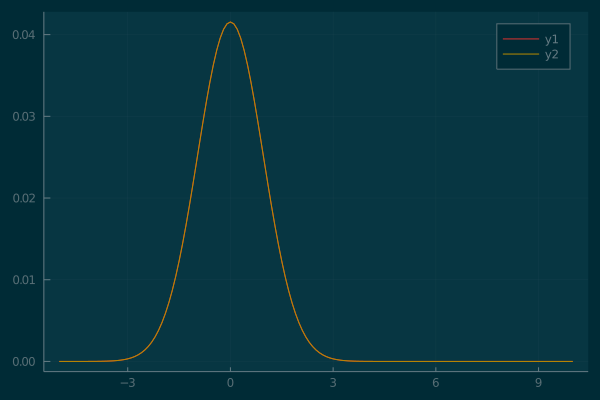

In [16]:
## test reproduction with unimodal distribution 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -5, 10, 0.1)
mu, sigma = moments(pop2.grid, pop2.trait[:,2])
dsn, R = AgeTraitStructuredModels.reproduction(pop2)
mu, sigma = reproduction(mu, sigma, Vle)
pdf1 = broadcast(x -> pdf(Distributions.Normal(mu,sigma),x),pop2.grid)
Plots.plot(pop2.grid, dsn)
Plots.plot!(pop2.grid, pdf1./sum(pdf1))

# dsn, R = AgeTraitStructuredModels.immigration(dsn, R, immigrants)

9.169802597119618e-16

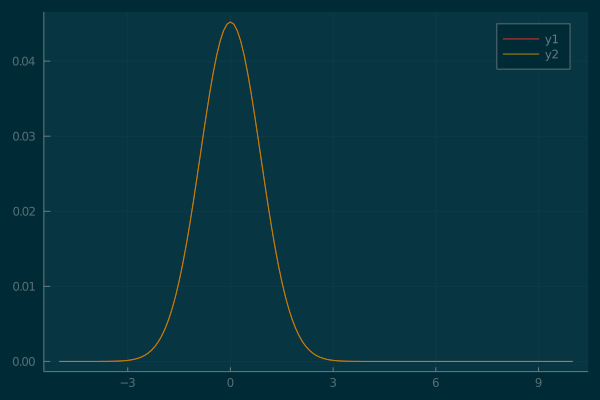

In [17]:
## test selection 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -5, 10, 0.1)
mu, sigma = moments(pop2.grid, pop2.trait[:,2])

dsn, R = AgeTraitStructuredModels.selection(pop2.trait[:,2], 1, pop2)
mu, sigma, p = selection(mu, sigma, s, theta)

pdf1 = broadcast(x -> pdf(Distributions.Normal(mu,sigma),x),pop2.grid)
p1 = Plots.plot(pop2.grid, dsn)
Plots.plot!(p1,pop2.grid, pdf1./sum(pdf1))
   
        
plot(p1)

In [18]:
floor(R, digits = 4) == floor(p,digits = 4)

true

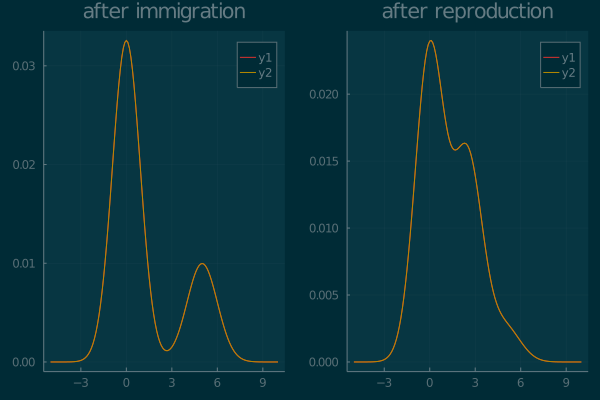

In [19]:
# test immigration 
pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -5, 10, 0.1)
mu, sigma = moments(pop2.grid, pop2.trait[:,2])
im = AgeTraitStructuredModels.init_imigrants(pop2, 1.0, 5)


dsn, R = AgeTraitStructuredModels.immigration(pop2.trait[:,2], 3.0, im)
p = [0.75, 0.25]
p1 = Plots.plot(pop2.grid, dsn)

mu = [mu, 5.0]
sigma = [sigma, sqrt(Vle)] 
pdf_ =  x ->  p[1]*pdf(Distributions.Normal(mu[1],sigma[1]),x) + p[2]*pdf(Distributions.Normal(mu[2],sigma[2]),x)
    
Plots.plot!(p1, pop2.grid, pdf_.(pop2.grid)./sum(pdf_.(pop2.grid)), 
                title = "after immigration")




# test reproduction, multimodal

p, mu, sds = reproduction(p[1], mu, sigma, Vle)

pdf1 =  x -> sum(broadcast( i -> p[i]*pdf(Distributions.Normal(mu[i],sds[i]),x),1:3))
    
p2 = Plots.plot(pop2.grid,pdf1.(pop2.grid)./sum(pdf1.(pop2.grid)))


pop2 = AgeTraitStructuredModels.init(mod2,Vle, theta, s, -5, 10, 0.1)
pop2.trait[:,2] = dsn
dsn, R = AgeTraitStructuredModels.reproduction(pop2)

Plots.plot!(p2, pop2.grid  , dsn, title = "after reproduction")

plot(p1,p2)

# Test initial conditions 

## tests selection ater density dependence

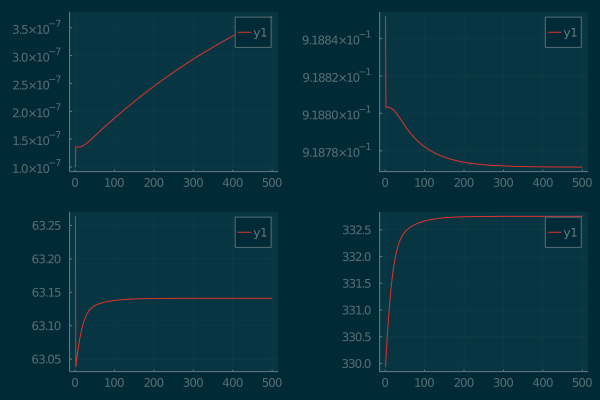

In [20]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")


# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod)

# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.1

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

# set populaiton dynamics function 
function time_step!(population)
    dsn, R = AgeTraitStructuredModels.reproduction(population)
    R = AgeTraitStructuredModels.recruitment(R, population )
    dsn, R = AgeTraitStructuredModels.selection(dsn, R, population)
    AgeTraitStructuredModels.ageing!(population, R, dsn)
end 


# simulate time series 
AgeTraitStructuredModels.reset!(pop,0.1)
T = 500
SSB = zeros(T)
recruits = zeros(T)
mean = zeros(T)
sds = zeros(T)

for t in 1:T
    mean[t], sds[t] = AgeTraitStructuredModels.trait_moments_recruits(pop)
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
    recruits[t] = AgeTraitStructuredModels.recruitment(pop)
    time_step!(pop)
    
end 
p1 = Plots.plot(mean)
p2 = Plots.plot(sds )
p3 = Plots.plot(recruits )
p4 = Plots.plot(SSB)
plot(p1,p2,p3, p4)

## test selection before density dependence

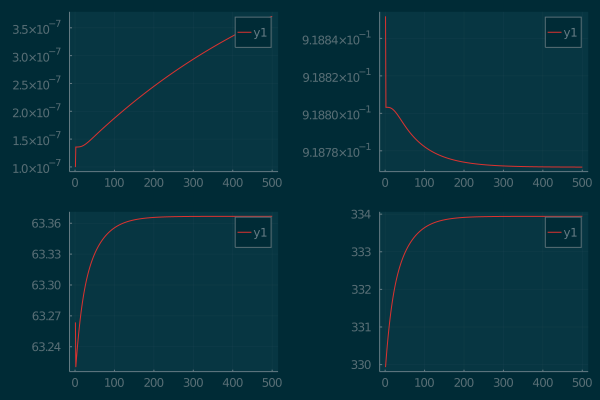

In [21]:

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod)

# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.1

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

# set populaiton dynamics function 
function time_step!(population)
    dsn, R = AgeTraitStructuredModels.reproduction(population)
    dsn, R = AgeTraitStructuredModels.selection(dsn, R, population)
    R = AgeTraitStructuredModels.recruitment(R, population, true )
    
    AgeTraitStructuredModels.ageing!(population, R, dsn)
end 

# simulate time series 
AgeTraitStructuredModels.reset!(pop,0.1)
T = 500
SSB = zeros(T)
recruits = zeros(T)
mean = zeros(T)
sds = zeros(T)

for t in 1:T
    mean[t], sds[t] = AgeTraitStructuredModels.trait_moments_recruits(pop)
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
    recruits[t] = AgeTraitStructuredModels.recruitment(pop)
    time_step!(pop)
    
end 
p1 = Plots.plot(mean)
p2 = Plots.plot(sds )
p3 = Plots.plot(recruits )
p4 = Plots.plot(SSB)
plot(p1,p2,p3, p4)

# Test `HatcheryPopulaitons.jl`



In [132]:
include("HatcheryPopulations.jl")

Main.HatcheryPopulations

In [133]:
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

# params
Vle = 1.0
theta_N = 0.0
s_N = 0.1

theta_D = 5.0
s_D = 0.1

dx = 0.1
min = -4
max = 9

hatch_pop = HatcheryPopulations.init(mod, Vle, theta_N, s_N, theta_D, s_D, min, max, dx)
print(" ")

In [140]:
HatcheryPopulations.reset!(hatch_pop, 0.05,0.1,0.2,5.0)


0.05

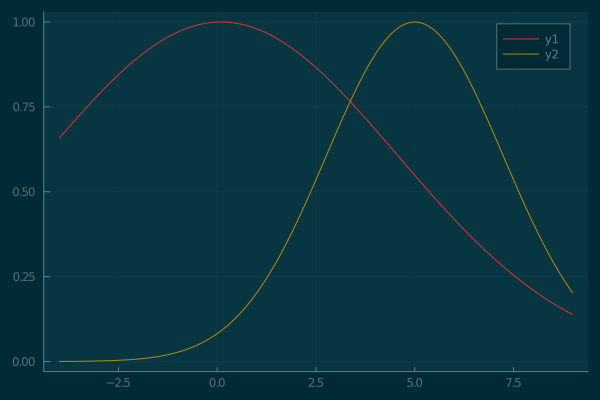

In [141]:
Plots.plot(hatch_pop.grid,hatch_pop.natural_gradient)
Plots.plot!(hatch_pop.grid,hatch_pop.domestic_gradient)